In [1]:
# Install and import libraries
%%capture
!pip install pmdarima

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pmdarima.arima as pmd
import warnings

# Warning suppression
warnings.filterwarnings('ignore')

In [2]:
# Set plot style
plt.style.use('bmh')

In [3]:
# Data input
file = 'HIST_PAINEL_COVIDBR_12mar2021.csv'
pivot_arg = ['data',
             'estado',
             'casosNovos']
horizon = 14
final_date = '2021-02-25'

In [4]:
# Function for transforming dataset into a time series
def pivot_table(data, args):
    index, columns, values = args
    table_case = data.pivot_table(index = index,
                                  columns = columns,
                                  values = values,
                                  aggfunc = np.sum,
                                  fill_value = 0)
    date_min = table_case.index.min()
    date_max = table_case.index.max()
    datas = pd.date_range(start=date_min, end=date_max)
    table_case.index = pd.to_datetime(table_case.index)
    table_case = table_case.reindex(index = datas.values, fill_value = 0)
    return table_case

# Function to calculate sMAPE error
def smape(a, p, factor=1):
    return 1/len(a) * np.sum(factor * np.abs(p - a) / (np.abs(a) + np.abs(p)))

# Function to build the ARIMA model and return error and predictions
def build_model(bm_train, bm_test, bm_horizon, data_season=7):
    predictions = []
    try:
        model = pmd.auto_arima(bm_train, m=data_season,
                               seasonal=True, error_action='ignore',
                               suppress_warnings=True, stepwise=False,
                               stationary=False)
        predictions = model.predict(n_periods=bm_horizon)
        bm_error = smape(bm_test, predictions)
    except ValueError:
        bm_error = np.float('NaN')
    return bm_error, predictions

In [5]:
# Load file, adjust dates and column names
dataset = pd.read_csv(file, sep = ';',
                      usecols = ['estado',
                                 'codmun',
                                 'data',
                                 'casosNovos'])
dataset = dataset[dataset.codmun.isnull()]
dataset = dataset.drop(columns = 'codmun').dropna()

# Pivot data and adjust the table
table_f = pivot_table(dataset, pivot_arg)
adjusted_table = table_f[table_f.index <= final_date]

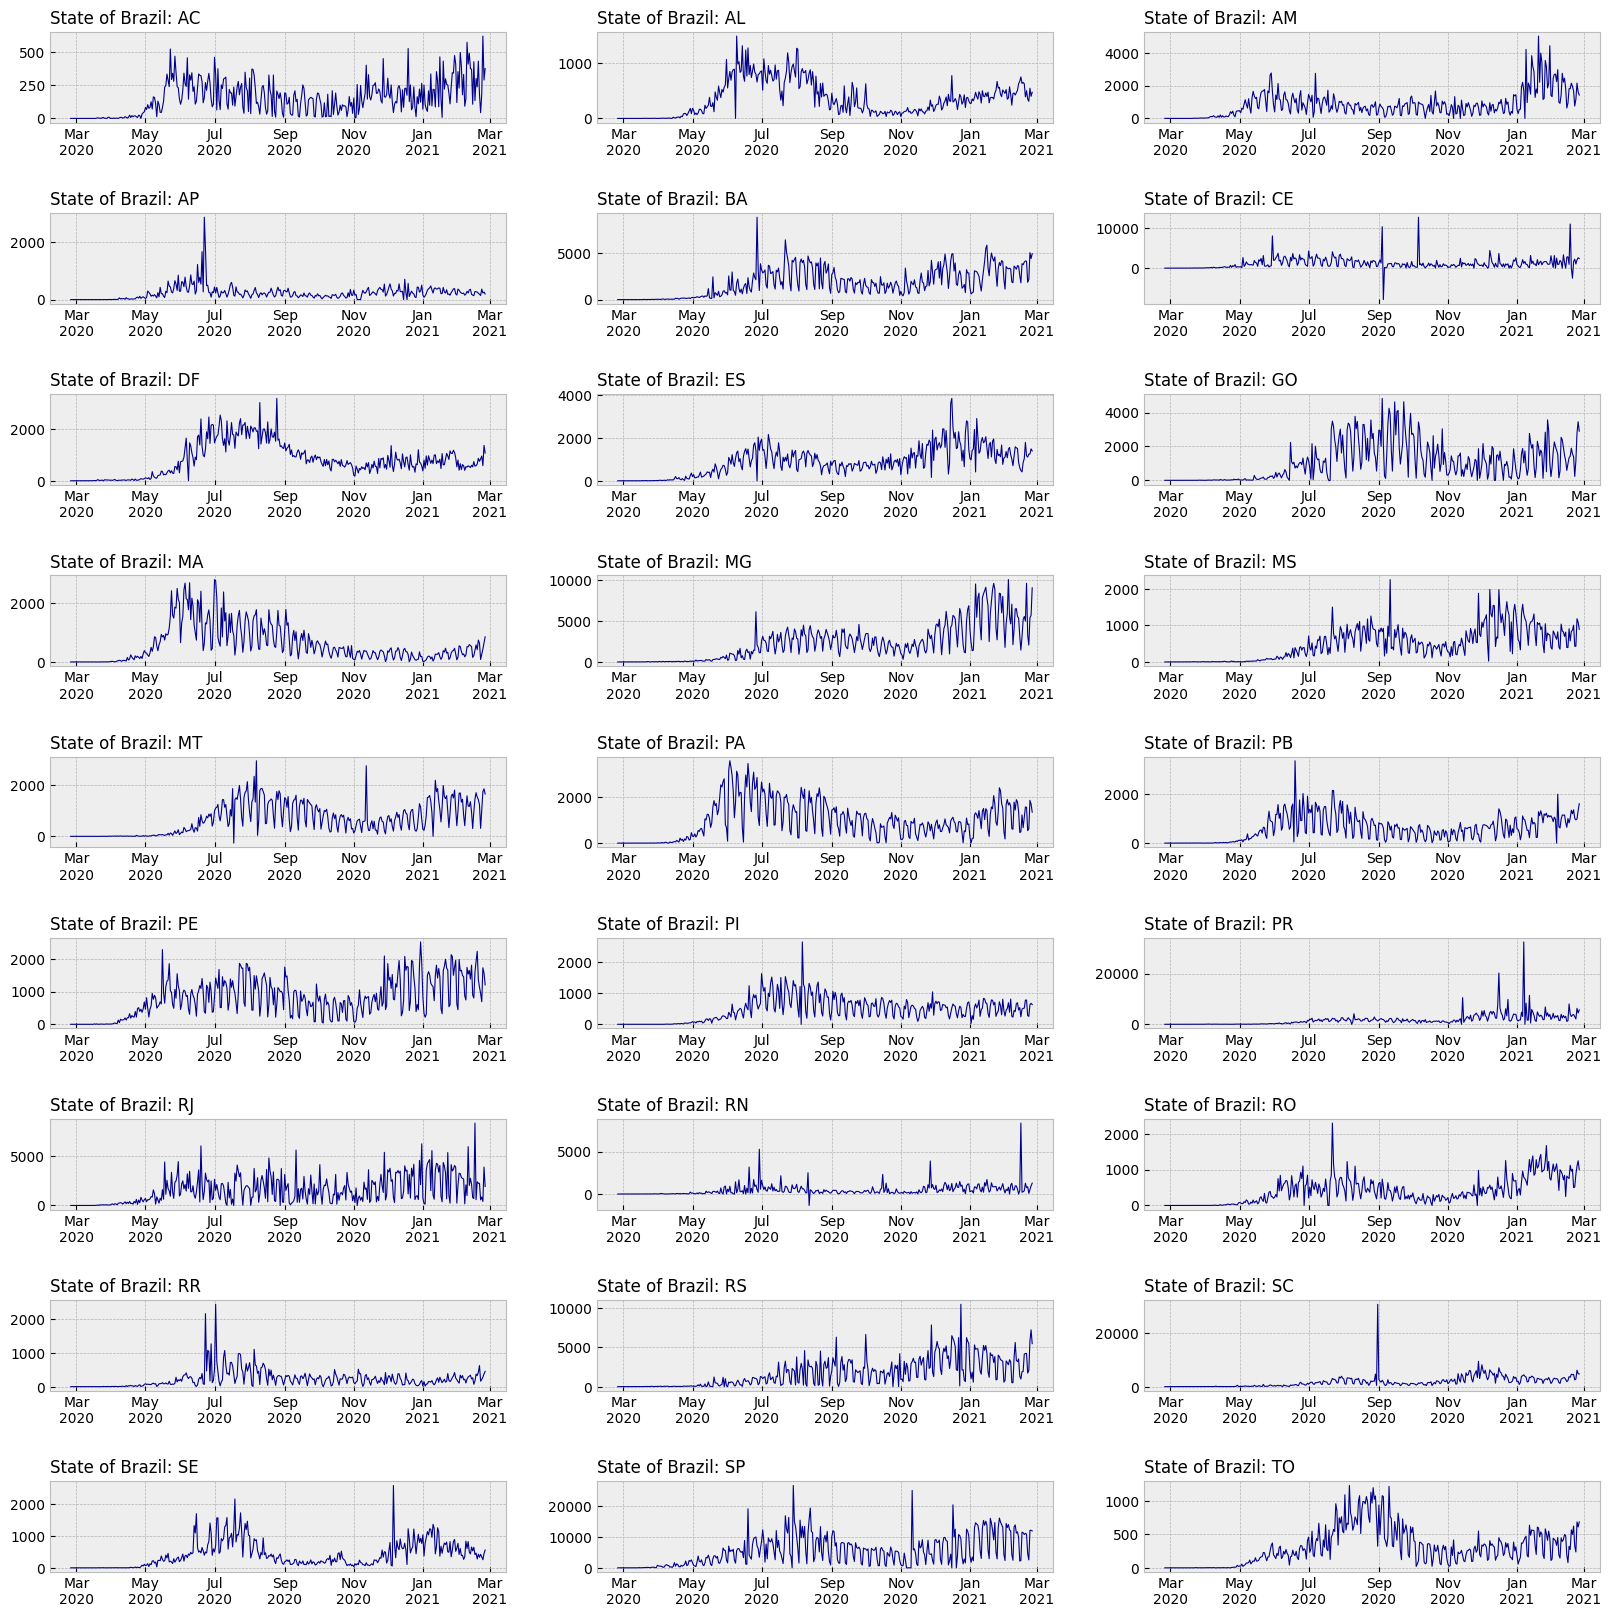

In [6]:
# Display data by state
plt.figure(figsize=(20, 20))
for i in range(len(adjusted_table.columns)):
    plt.subplot(9, 3, i+1)
    plt.plot(adjusted_table.iloc[:, i], color='darkblue', linewidth=0.8)
    plt.title('State of Brazil: {}'.format(adjusted_table.columns[i]),
              loc='left', fontsize=12)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)
    #plt.ylabel('Incidence', fontsize=10)
    #plt.xlabel("Date", fontsize=10)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    plt.subplots_adjust(hspace=1.0)
plt.savefig('/graphs/Fig3.eps', dpi = 600)
plt.show()

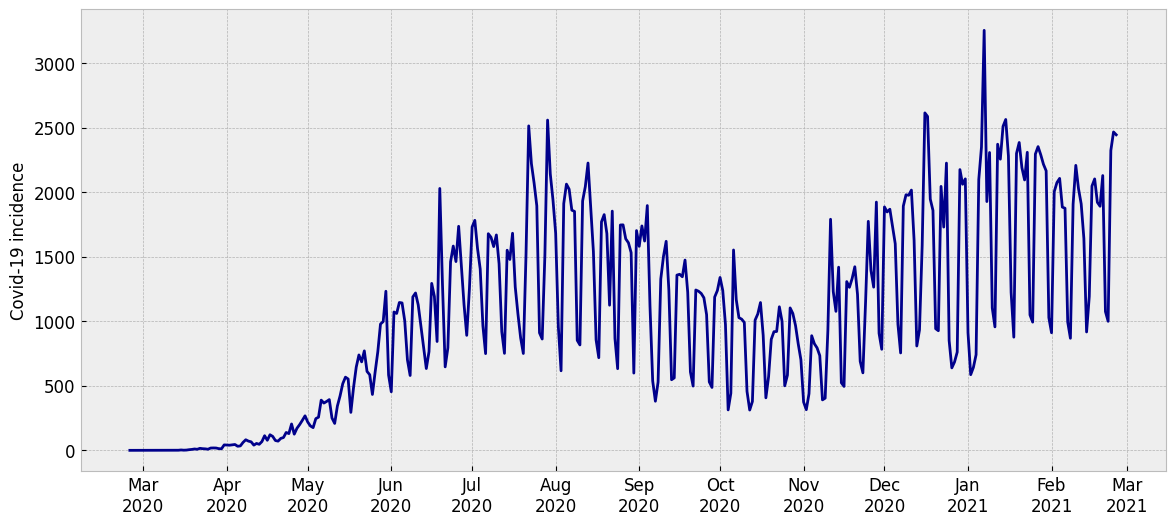

In [7]:
# Display consolidated data
plt.figure(figsize=(14, 6))
plt.plot(adjusted_table.mean(axis=1), color='darkblue')
plt.ylabel('Covid-19 incidence', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.savefig('/graphs/Fig4.eps', dpi = 600)
plt.show()

In [8]:
# Save the adjusted table
adjusted_table.to_csv('/data/adjusted_table.csv')

In [ ]:
# Executa a modelagem, predição e cálculo do erro em cada coluna
results = pd.DataFrame(index = adjusted_table[(horizon - 1):-horizon].index)
for br_state in adjusted_table:
    table = adjusted_table['SC']
    errors = list()
    for window in table.expanding():
        if len(window) >= horizon * 2:
            train = window[:-horizon]
            test = window[-horizon:]
            if len(test) >= horizon:
                error, preds = build_model(train, test, horizon)
                print('{},{}'.format(br_state, error),
                      file = open('_results.txt', 'a'))
                print('{},{}'.format(br_state, preds),
                      file = open('_predictions.txt', 'a'))
                print('{},{}'.format(br_state, test.values),
                      file = open('_test_set.txt', 'a'))
                errors.append(error)
    results[br_state] = errors

results.to_csv('/data/results.csv')